# Welcome to my kernel
Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

This the **HAM10000 ("Human Against Machine with 10000 training images")** dataset.It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**

In this kernel I will try to detect 7 different classes of skin cancer using Convolution Neural Network with keras tensorflow in backend and then analyse the result to see how the model can be useful in practical scenario.<br>
We will move step by step process to classify 7 classes of cancer.

In this kernel I have followed following 14 steps for model building and evaluation which are as follows : <br>
**Step 1 : Importing Essential Libraries**<br>
**Step 2: Making Dictionary of images and labels** <br>
**Step 3: Reading and Processing Data** <br>
**Step 4: Data Cleaning** <br>
**Step 5: Exploratory data analysis (EDA)** <br>
**Step 6: Loading & Resizing of images **<br>
**Step 7: Train Test Split**<br>
**Step 8: Normalization**<br>
**Step 9: Label Encoding** <br>
**Step 10: Train validation split** <br>
**Step 11: Model Building (CNN)** <br>
**Step 12: Setting Optimizer & Annealing** <br>
**Step 13: Fitting the model**<br>
**Step 14: Model Evaluation (Testing and validation accuracy, confusion matrix, analysis of misclassified instances)** <br>

<img src="https://image.ibb.co/n8PBkL/cover.png">

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1 : importing Essential Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from keras.utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [ ]:
import tensorflow as tf

In [ ]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


# Step 2 : Making Dictionary of images and labels
In this step I have made the image path dictionary by joining the folder path from base directory base_skin_dir and merge the images in jpg format from both the folders HAM10000_images_part1.zip and HAM10000_images_part2.zip

In [ ]:
base_skin_dir = '/content/drive/MyDrive/COLABDATA/hm10000'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Step 3 : Reading & Processing data

In this step we have read the csv by joining the path of image folder which is the base folder where all the images are placed named base_skin_dir.
After that we made some new columns which is easily understood for later reference such as we have made column path which contains the image_id, cell_type which contains the short name of lesion type and at last we have made the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [ ]:


skin_df = pd.read_csv(os.path.join('/content/drive/MyDrive/COLABDATA/hm10000', 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Actinic keratoses,0


# Step 4 : Data Cleaning
In this step we check for Missing values and datatype of each field

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

Now, lets check the presence of null values  again

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [ ]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# Step 6: Loading and resizing of images
In this step images will be loaded into the column named image from the image path from the image folder. We also resize the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75. As this step resize all the 10015 images dimensions into 100x 75 so be patient it will take some time.

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/COLABDATA/hm10000/HAM10...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


**As we can see image column has been added in its color format code**

Most interesting part its always better to see sample of images
Below we will show images of each cancer type

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Step 7 : Train Test Split
In this step we have splitted the dataset into training and testing set of 80:20 ratio

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# Step 8 : Normalization

I choosed to normalize the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 9 : Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Step 10 : Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# Step 11: Model Building
# CNN
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_optimized_vgg16(input_shape, num_classes):
    model = Sequential()
    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Classification block
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Define the input shape and number of classes
input_shape = (75, 100, 3)
num_classes = 7

# Build the optimized VGG16 model
model = build_optimized_vgg16(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 75, 100, 32)       896       
                                                                 
 conv2d_43 (Conv2D)          (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 37, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 37, 50, 64)        18496     
                                                                 
 conv2d_45 (Conv2D)          (None, 37, 50, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 18, 25, 64)       0         
 g2D)                                                 

# Step 12: Setting Optimizer and Annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.
We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".
The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.
I choosed Adam optimizer because it combines the advantages of two other extensions of stochastic gradient descent. Specifically:

1. Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

2. Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

# Data Augmentation
It is the optional step. In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


For the data augmentation, i choosed to :
Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height
Once our model is ready, we fit the training dataset .

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 13: Fitting the model
In this step finally I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs   as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import Adam

optimizer = Adam()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fit the model
epochs = 50
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


<ipython-input-43-63703d5b2f52>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


720/721 [============================>.] - ETA: 0s - loss: 1.1835 - accuracy: 0.6572

721/721 [==============================] - 29s 30ms/step - loss: 1.1829 - accuracy: 0.6574 - val_loss: 1.1255 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 2/50
721/721 [==============================] - ETA: 0s - loss: 1.1387 - accuracy: 0.6712

721/721 [==============================] - 22s 30ms/step - loss: 1.1387 - accuracy: 0.6712 - val_loss: 1.1273 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 3/50
720/721 [============================>.] - ETA: 0s - loss: 1.1379 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1379 - accuracy: 0.6712 - val_loss: 1.1173 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 4/50
719/721 [============================>.] - ETA: 0s - loss: 1.1340 - accuracy: 0.6709

721/721 [==============================] - 20s 28ms/step - loss: 1.1336 - accuracy: 0.6712 - val_loss: 1.1199 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 5/50
721/721 [==============================] - ETA: 0s - loss: 1.1326 - accuracy: 0.6712

721/721 [==============================] - 22s 30ms/step - loss: 1.1326 - accuracy: 0.6712 - val_loss: 1.1169 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 6/50
719/721 [============================>.] - ETA: 0s - loss: 1.1314 - accuracy: 0.6711

721/721 [==============================] - 22s 30ms/step - loss: 1.1313 - accuracy: 0.6712 - val_loss: 1.1161 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 7/50
720/721 [============================>.] - ETA: 0s - loss: 1.1319 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1319 - accuracy: 0.6712 - val_loss: 1.1174 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 8/50
721/721 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1319 - accuracy: 0.6712 - val_loss: 1.1171 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 9/50
720/721 [============================>.] - ETA: 0s - loss: 1.1320 - accuracy: 0.6708

721/721 [==============================] - 21s 29ms/step - loss: 1.1311 - accuracy: 0.6712 - val_loss: 1.1198 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 10/50
721/721 [==============================] - ETA: 0s - loss: 1.1307 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1307 - accuracy: 0.6712 - val_loss: 1.1210 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 11/50
720/721 [============================>.] - ETA: 0s - loss: 1.1322 - accuracy: 0.6711

721/721 [==============================] - 20s 28ms/step - loss: 1.1319 - accuracy: 0.6712 - val_loss: 1.1169 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 12/50
720/721 [============================>.] - ETA: 0s - loss: 1.1304 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1307 - accuracy: 0.6712 - val_loss: 1.1150 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 13/50
720/721 [============================>.] - ETA: 0s - loss: 1.1300 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1297 - accuracy: 0.6712 - val_loss: 1.1172 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 14/50
720/721 [============================>.] - ETA: 0s - loss: 1.1306 - accuracy: 0.6711

721/721 [==============================] - 20s 28ms/step - loss: 1.1308 - accuracy: 0.6712 - val_loss: 1.1176 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 15/50
719/721 [============================>.] - ETA: 0s - loss: 1.1304 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1299 - accuracy: 0.6712 - val_loss: 1.1168 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 16/50
721/721 [==============================] - ETA: 0s - loss: 1.1302 - accuracy: 0.6712

721/721 [==============================] - 20s 28ms/step - loss: 1.1302 - accuracy: 0.6712 - val_loss: 1.1151 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 17/50
720/721 [============================>.] - ETA: 0s - loss: 1.1306 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1305 - accuracy: 0.6712 - val_loss: 1.1200 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 18/50
720/721 [============================>.] - ETA: 0s - loss: 1.1299 - accuracy: 0.6712

721/721 [==============================] - 21s 29ms/step - loss: 1.1302 - accuracy: 0.6712 - val_loss: 1.1217 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 19/50
719/721 [============================>.] - ETA: 0s - loss: 1.1314 - accuracy: 0.6708

721/721 [==============================] - 24s 33ms/step - loss: 1.1303 - accuracy: 0.6712 - val_loss: 1.1183 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 20/50
720/721 [============================>.] - ETA: 0s - loss: 1.1299 - accuracy: 0.6714

721/721 [==============================] - 21s 29ms/step - loss: 1.1306 - accuracy: 0.6712 - val_loss: 1.1158 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 21/50
720/721 [============================>.] - ETA: 0s - loss: 1.1301 - accuracy: 0.6712

721/721 [==============================] - 21s 29ms/step - loss: 1.1301 - accuracy: 0.6712 - val_loss: 1.1195 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 22/50
721/721 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.6712

721/721 [==============================] - 21s 29ms/step - loss: 1.1298 - accuracy: 0.6712 - val_loss: 1.1158 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 23/50
720/721 [============================>.] - ETA: 0s - loss: 1.1302 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1302 - accuracy: 0.6712 - val_loss: 1.1164 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 24/50
719/721 [============================>.] - ETA: 0s - loss: 1.1315 - accuracy: 0.6709

721/721 [==============================] - 20s 28ms/step - loss: 1.1307 - accuracy: 0.6712 - val_loss: 1.1154 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 25/50
720/721 [============================>.] - ETA: 0s - loss: 1.1303 - accuracy: 0.6710

721/721 [==============================] - 22s 31ms/step - loss: 1.1299 - accuracy: 0.6712 - val_loss: 1.1174 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 26/50
721/721 [==============================] - ETA: 0s - loss: 1.1296 - accuracy: 0.6712

721/721 [==============================] - 21s 29ms/step - loss: 1.1296 - accuracy: 0.6712 - val_loss: 1.1155 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 27/50
721/721 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.6712

721/721 [==============================] - 20s 28ms/step - loss: 1.1305 - accuracy: 0.6712 - val_loss: 1.1172 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 28/50
720/721 [============================>.] - ETA: 0s - loss: 1.1312 - accuracy: 0.6708

721/721 [==============================] - 22s 31ms/step - loss: 1.1305 - accuracy: 0.6712 - val_loss: 1.1192 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 29/50
721/721 [==============================] - ETA: 0s - loss: 1.1299 - accuracy: 0.6712

721/721 [==============================] - 24s 33ms/step - loss: 1.1299 - accuracy: 0.6712 - val_loss: 1.1176 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 30/50
721/721 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.6712

721/721 [==============================] - 20s 28ms/step - loss: 1.1298 - accuracy: 0.6712 - val_loss: 1.1159 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 31/50
719/721 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.6713

721/721 [==============================] - 22s 31ms/step - loss: 1.1295 - accuracy: 0.6712 - val_loss: 1.1165 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 32/50
721/721 [==============================] - ETA: 0s - loss: 1.1288 - accuracy: 0.6712

721/721 [==============================] - 21s 29ms/step - loss: 1.1288 - accuracy: 0.6712 - val_loss: 1.1154 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 33/50
720/721 [============================>.] - ETA: 0s - loss: 1.1302 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1302 - accuracy: 0.6712 - val_loss: 1.1200 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 34/50
720/721 [============================>.] - ETA: 0s - loss: 1.1298 - accuracy: 0.6714

721/721 [==============================] - 21s 29ms/step - loss: 1.1304 - accuracy: 0.6712 - val_loss: 1.1166 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 35/50
720/721 [============================>.] - ETA: 0s - loss: 1.1307 - accuracy: 0.6707

721/721 [==============================] - 21s 29ms/step - loss: 1.1297 - accuracy: 0.6712 - val_loss: 1.1152 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 36/50
720/721 [============================>.] - ETA: 0s - loss: 1.1301 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1305 - accuracy: 0.6712 - val_loss: 1.1142 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 37/50
720/721 [============================>.] - ETA: 0s - loss: 1.1285 - accuracy: 0.6714

721/721 [==============================] - 20s 28ms/step - loss: 1.1293 - accuracy: 0.6712 - val_loss: 1.1167 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 38/50
720/721 [============================>.] - ETA: 0s - loss: 1.1307 - accuracy: 0.6708

721/721 [==============================] - 22s 31ms/step - loss: 1.1299 - accuracy: 0.6712 - val_loss: 1.1141 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 39/50
721/721 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.6712

721/721 [==============================] - 23s 32ms/step - loss: 1.1303 - accuracy: 0.6712 - val_loss: 1.1173 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 40/50
720/721 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.6711

721/721 [==============================] - 21s 30ms/step - loss: 1.1295 - accuracy: 0.6712 - val_loss: 1.1164 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 41/50
720/721 [============================>.] - ETA: 0s - loss: 1.1296 - accuracy: 0.6714

721/721 [==============================] - 24s 33ms/step - loss: 1.1299 - accuracy: 0.6712 - val_loss: 1.1155 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 42/50
721/721 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.6712

721/721 [==============================] - 21s 29ms/step - loss: 1.1298 - accuracy: 0.6712 - val_loss: 1.1166 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 43/50
721/721 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.6712

721/721 [==============================] - 20s 28ms/step - loss: 1.1303 - accuracy: 0.6712 - val_loss: 1.1178 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 44/50
720/721 [============================>.] - ETA: 0s - loss: 1.1292 - accuracy: 0.6711

721/721 [==============================] - 22s 31ms/step - loss: 1.1290 - accuracy: 0.6712 - val_loss: 1.1156 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 45/50
719/721 [============================>.] - ETA: 0s - loss: 1.1297 - accuracy: 0.6709

721/721 [==============================] - 22s 30ms/step - loss: 1.1294 - accuracy: 0.6712 - val_loss: 1.1190 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 46/50
720/721 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.6711

721/721 [==============================] - 21s 29ms/step - loss: 1.1296 - accuracy: 0.6712 - val_loss: 1.1149 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 47/50
721/721 [==============================] - ETA: 0s - loss: 1.1291 - accuracy: 0.6712

721/721 [==============================] - 22s 30ms/step - loss: 1.1291 - accuracy: 0.6712 - val_loss: 1.1214 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 48/50
720/721 [============================>.] - ETA: 0s - loss: 1.1297 - accuracy: 0.6714

721/721 [==============================] - 21s 28ms/step - loss: 1.1301 - accuracy: 0.6712 - val_loss: 1.1161 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 49/50
721/721 [==============================] - ETA: 0s - loss: 1.1291 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1291 - accuracy: 0.6712 - val_loss: 1.1199 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 50/50
721/721 [==============================] - ETA: 0s - loss: 1.1297 - accuracy: 0.6712

721/721 [==============================] - 22s 31ms/step - loss: 1.1297 - accuracy: 0.6712 - val_loss: 1.1178 - val_accuracy: 0.6808 - lr: 0.0010


# Step 14: Model Evaluation
In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")


26/26 [==============================] - 0s 9ms/step - loss: 0.9422 - accuracy: 0.6870
Validation: accuracy = 0.687032  ;  loss_v = 0.942204
Test: accuracy = 0.681977  ;  loss = 0.961099


KeyError: ignored

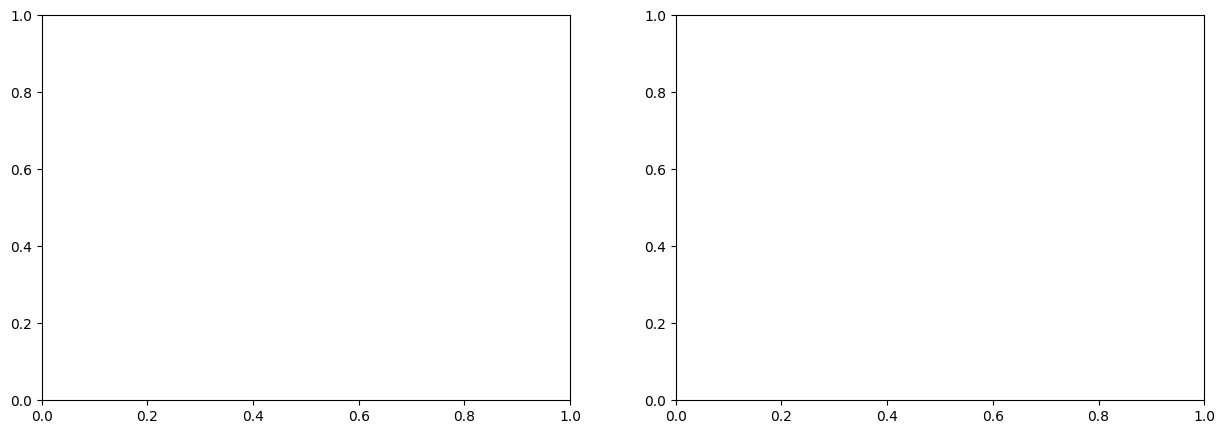

In [ ]:
plot_model_history(history)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Now, lets which category has much incorrect predictions

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

# Conclusion
It seems our model has maximum number of incorrect predictions for Basal cell carcinoma which has code 3, then second most missclassified type is Vascular lesions code 5 then Melanocytic nevi code  0 where as Actinic keratoses code 4 has least misclassified type.

We can also further tune our model to easily achieve the accuracy above 80% and I think still this model is efficient in comparison to detection with human eyes having 77.0344% accuracy

I hope kagglers like my stepwise approach to classify cancer types. If like then kindly dont forget to hit the **like**
